# Analysis of DEA results - efficiency, slacks, peer relations

***
## Imports and data

In [276]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import statsmodels.api as sm
from fill_and_map import map_inds_sdg, fill_econ, map_econ_sdg, fill_inds_trans
fpath = Path('data_raw/SDG-DEA_indicators_V5_20200708.xlsx')

In [277]:
# read income and efficiency data
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_io.csv'), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

In [272]:
# general plot data
cmap = np.divide([[140,107,177],
                 [199,233,180],
                 [158,188,218],
                 [65,182,196]],255)       
nbins = 12


***
## Improvement targets/slacks

In [51]:
# # improvement target (slack) analysis
spath = Path('analysis_data/slacks_oo.xlsx')
writer = pd.ExcelWriter(spath, engine='xlsxwriter')
slacks = {}
for s in range(1,18):
    slacks[s] = pd.read_excel(writer, sheet_name = 'sdg{0}'.format(s), index_col=0)

# for s in all_res[orient].keys():
#     n_countries = all_res[orient][s].shape[0]
#     all_res[orient][s].iloc[:,1:-n_countries].to_excel(writer, sheet_name=s)
# writer.save()

***
## Analysis of economic data
Things to add:
- income categories (categorical) vs. spend for each economic input
- same thing, but spend as percentage of GDP

In [251]:
econ = fill_econ(fpath)
map_econ = map_econ_sdg(fpath)
inds = fill_inds_trans(fpath)

In [254]:
econ.columns

Index(['Income Group in 2019',
       'Expenditure_on_agriculture_fishing_forestry__hunting',
       'Expenditure_on_health', 'Expenditure_on_education',
       'Expenditure_on_social_protection', 'Rest_of_COFOG_not_defined'],
      dtype='object')

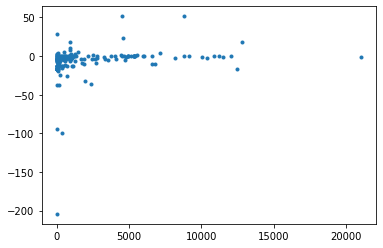

In [257]:
plt.scatter(econ['Expenditure_on_social_protection'],inds['sdg10_fsi7'], marker='.', mark)

In [66]:
for ii in econ.columns[1:]:
    print(ii, econ.loc[:,ii].sort_values()[:10])

Expenditure_on_agriculture_fishing_forestry__hunting MWI    0.376766
COD    1.021209
MDG    1.919638
GNB    2.452220
LBR    3.143710
BDI    3.148916
NGA    3.159543
SDN    3.322496
CAF    4.024145
SLE    5.833959
Name: Expenditure_on_agriculture_fishing_forestry__hunting, dtype: float64
Expenditure_on_health COD     5.426226
CAF     5.598660
NER    13.014719
BDI    13.707434
HTI    14.137400
TCD    14.223931
GMB    17.153876
GIN    17.465929
BGD    17.763416
UGA    17.932908
Name: Expenditure_on_health, dtype: float64
Expenditure_on_education COD    15.789776
TCD    35.431022
BDI    38.158755
LBR    38.684400
NER    42.686542
UGA    45.204557
HTI    49.135771
MWI    49.310943
GMB    52.163864
MDG    52.180982
Name: Expenditure_on_education, dtype: float64
Expenditure_on_social_protection BDI    1.523048
TCD    1.580437
BFA    1.859648
CAF    2.799330
STP    3.944693
PNG    4.233124
TZA    5.028488
HTI    5.301525
UGA    5.379872
LBR    5.988019
Name: Expenditure_on_social_protection, d

***
## Analysis of peer relationships

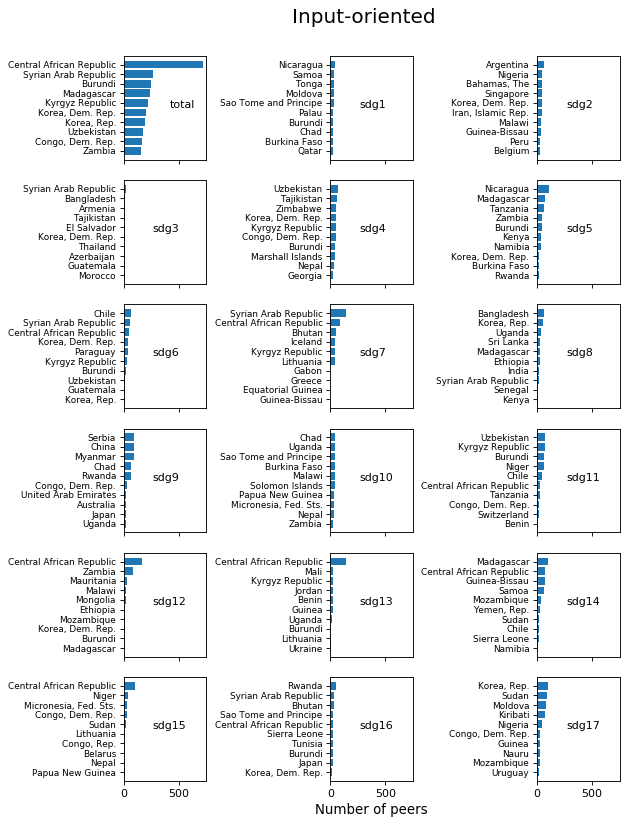

In [38]:
# # Peer analysis

# read peer excel file
orient = 'io'
cid = pd.read_csv('analysis_data/country_id.csv', index_col=[1]) # country id to transform from three-letter iso code to name
xls = pd.ExcelFile(Path('analysis_data/lambdas_{0}.xlsx'.format(orient))) # so we don't have to reload the file for each sheet
peer_data = {}
sdg_strings = ['sdg{0}'.format(ii) for ii in range(1,18)]
for s in sdg_strings:
    peer_data[s] = pd.read_excel(xls, s, index_col=[0])
    peer_data[s].columns = cid['c']
    peer_data[s].index = cid['c']

cutoff = 0.001 # so we don't consider very weak peer relationships
peer_counts = {}

# count number of times a country has acted as peer, minus "self-peering"
for s in sdg_strings:
    peer_counts[s] = peer_data[s][peer_data[s] > cutoff].count() - np.diag(peer_data[s])

# plot peer counts
nc = 10 # number of countries to display

y_pos = np.arange(nc)
fig, ax = plt.subplots(6, 3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(wspace=1.5)
ax = ax.ravel()

for jj, ax0 in enumerate(ax):
    sdg_n = sdg_strings[jj-1]
    if jj==0:
        plot_counts = sum(peer_counts.values()).sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.55,.5,'total',transform=ax0.transAxes)
    else:
        plot_counts = peer_counts[sdg_n].sort_values()[-nc:]
        ax0.barh(y_pos, plot_counts)
        ax0.text(.35,.5,sdg_n,transform=ax0.transAxes)

    ax0.set_yticks(y_pos)
    ax0.set_yticklabels(plot_counts.index, fontsize=8)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Number of peers", fontsize=12)
# ax3.set_ylabel("Counts", fontsize=12)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_oo.png', bbox_inches='tight', dpi=600)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.93, fontsize=18)
    plt.savefig('figures/peercount_all_io.png', bbox_inches='tight', dpi=600)



***
## Miscellaneous 
### Desired/undesired outputs

In [40]:
# number of desired/undesired outputs for each SDG
map_inds = map_inds_sdg(fpath)
use_inds_path = Path('data_raw/use_inds.xlsx')
use_inds = pd.read_excel(use_inds_path, usecols='A:D')
skip_inds = use_inds['ind_name'][use_inds['use']=='no']
undes_inds = use_inds['ind_name'][use_inds['issue']=='undesired']


for ii in map_inds:
    n_ind = len(set(map_inds[ii]) - set(skip_inds))
    n_undes = len(set(map_inds[ii]) & set(undes_inds) - set(skip_inds))
    n_des = n_ind - n_undes
    print('SDG {0}:'.format(ii),'{0} ({1}/{2})'.format(n_ind, n_des, n_undes))


SDG 1: 4 (4/0)
SDG 2: 8 (6/2)
SDG 3: 17 (15/2)
SDG 4: 3 (3/0)
SDG 5: 4 (4/0)
SDG 6: 5 (3/2)
SDG 7: 3 (3/0)
SDG 8: 6 (5/1)
SDG 9: 5 (5/0)
SDG 10: 8 (5/3)
SDG 11: 3 (3/0)
SDG 12: 6 (0/6)
SDG 13: 4 (2/2)
SDG 14: 4 (2/2)
SDG 15: 6 (4/2)
SDG 16: 8 (6/2)
SDG 17: 4 (3/1)


In [263]:
pi = Path('analysis_data/updated_sdg10/sdg10_eff_res_io.csv')
po = Path('analysis_data/updated_sdg10/sdg10_eff_res_oo.csv')
s10io = pd.read_csv(pi, sep='\t', index_col=[0])
s10oo = pd.read_csv(po, sep='\t', index_col=[0])

In [269]:
[(ii,s10io.loc[ii]['eff']) for ii in s10io['eff'].sort_values().index]

[('SMR', 0.0007311361),
 ('HRV', 0.0010237291),
 ('BGR', 0.0015009103),
 ('SRB', 0.0020976325),
 ('ALB', 0.0021245662),
 ('ATG', 0.002360774),
 ('TUR', 0.0023883713),
 ('IRN', 0.0025427457),
 ('MCO', 0.0026052285),
 ('LIE', 0.0026052285),
 ('AND', 0.0026052285),
 ('TUN', 0.0033515412),
 ('EGY', 0.0035615975),
 ('MUS', 0.0038630347),
 ('BIH', 0.0046947813),
 ('GRC', 0.0046989367),
 ('VEN', 0.004748182199999999),
 ('AZE', 0.0049324842),
 ('NRU', 0.0051104301000000005),
 ('TUV', 0.0051351661),
 ('CUB', 0.0051893733),
 ('PRT', 0.005744646999999999),
 ('LKA', 0.0062049747),
 ('BTN', 0.006544415400000001),
 ('JOR', 0.0067195495),
 ('DZA', 0.0071247173),
 ('ARM', 0.0072557787),
 ('LBY', 0.0074406851),
 ('MNE', 0.007973538),
 ('KGZ', 0.0081224944),
 ('SYC', 0.008374333199999999),
 ('VCT', 0.0085439444),
 ('CPV', 0.0087740062),
 ('BWA', 0.0106710994),
 ('LBN', 0.0113243907),
 ('BHR', 0.011402641299999999),
 ('MAR', 0.0114551291),
 ('TTO', 0.012455046),
 ('LAO', 0.0127628502),
 ('COL', 0.0132915

***
## Efficiency analysis

In [278]:
# read income and efficiency data
orient = 'oo'
ic_in = pd.read_csv(Path('analysis_data/income_cats.csv'), index_col=0, header=None)
ef_in = pd.read_csv(Path('analysis_data/eff_{0}.csv'.format(orient)), index_col=0)

# concat into one dataframe
eff = pd.concat((ic_in, ef_in), axis=1)
eff.columns = ['income',*eff.columns[1:]]
inc = eff['income'].unique()

In [248]:
pth1 = Path('gams_output_files/old/sdg10_eff_res_oo.csv')
pth2 = Path('gams_output_files/old/sdg10_2.csv')
pd.read_csv(pth1, sep='\t', index_col=[0]).to_csv(pth2)

In [243]:
[(ii,eff['sdg10'].sort_values()[ii]) for ii in eff['sdg10'].sort_values().index]

[('GIN', 4e-08),
 ('SLV', 0.8101472667),
 ('SMR', 0.8592883319),
 ('LKA', 0.8792135637),
 ('VEN', 0.8830246793000001),
 ('CPV', 0.8876218994),
 ('EGY', 0.8879000834999999),
 ('MEX', 0.8897922863),
 ('ECU', 0.8901707639),
 ('GRC', 0.8904230874),
 ('TUR', 0.8932946740000001),
 ('GEO', 0.8943977873000001),
 ('PHL', 0.8981067594),
 ('COL', 0.8984292353),
 ('LBY', 0.8991452343),
 ('MUS', 0.8992619570999999),
 ('VCT', 0.8997105301),
 ('NRU', 0.8997410015999999),
 ('CUB', 0.9000112012),
 ('DMA', 0.9000625309),
 ('MKD', 0.9024077443),
 ('GTM', 0.9034332775),
 ('ALB', 0.9037056432),
 ('ARM', 0.9047471014),
 ('GUY', 0.9052842329),
 ('JOR', 0.9074815557),
 ('MYS', 0.9085868825),
 ('LCA', 0.9088189012),
 ('ROU', 0.9119714702),
 ('TKM', 0.9140310175),
 ('RUS', 0.9141343919),
 ('AFG', 0.9149012519),
 ('SSD', 0.9149127311),
 ('SYC', 0.9152815397),
 ('MNE', 0.9158556432),
 ('IRN', 0.9159140155),
 ('AZE', 0.9175977643),
 ('TUV', 0.9183697074),
 ('PRT', 0.9184075265),
 ('GRD', 0.9186472824),
 ('NAM', 0.

### Countries with most 100% efficiency scores

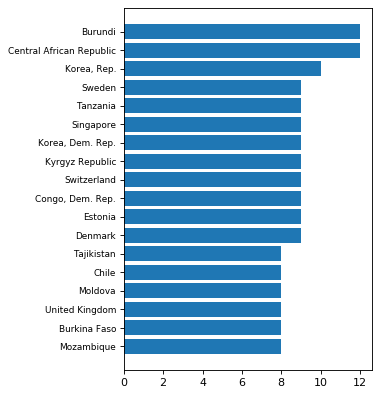

In [144]:
# which countries are most often efficient

nc = 18 # number of countries to display
freq_eff = eff[eff==1].sum(axis=1).sort_values(ascending=True)[-nc:]
freq_eff.index = [cid.loc[ii,'c'] for ii in freq_eff.index] # change country code to full name

y_pos = np.arange(nc)

fig, ax = plt.subplots(1, 1, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
ax.barh(y_pos, freq_eff)
ax.set_yticks(y_pos)
ax.set_yticklabels(freq_eff.index, fontsize=8);


### Boxplots, beanplots, etc.

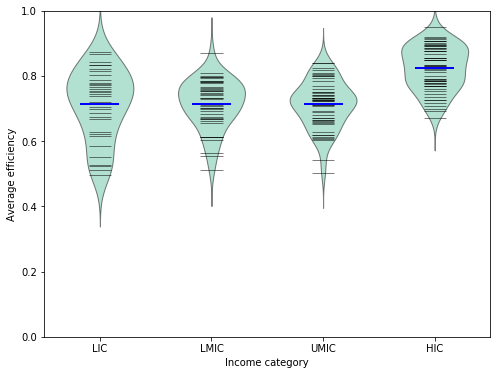

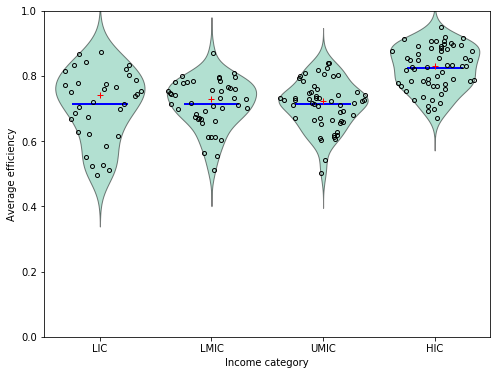

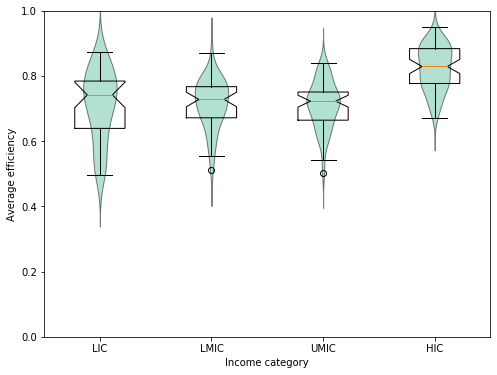

In [279]:
# beanplots - single

data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
def bean(data, labels, plot_opts={}, jitter=False):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}

    plot_opts_.update(plot_opts)
    sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")
    ax.set_ylim(0,1)

def violin(data, labels):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plot_opts={'violin_width':.3}
    sm.graphics.violinplot(data, ax=ax, labels=labels, plot_opts=plot_opts)
    ax.set_xlabel("Income category")
    ax.set_ylabel("Average efficiency")    
    ax.set_ylim(0,1)

# fig = bean([eff[cc] for cc in eff.columns[1:]], labels=eff.columns[1:])
fig = bean(data, labels=inc, plot_opts={'violin_width':.6, 'bean_size':.2, 'bean_show_median':False, 'bean_mean_size':.35})
fig = bean(data, labels=inc, jitter=True)
fig = violin(data, labels=inc)

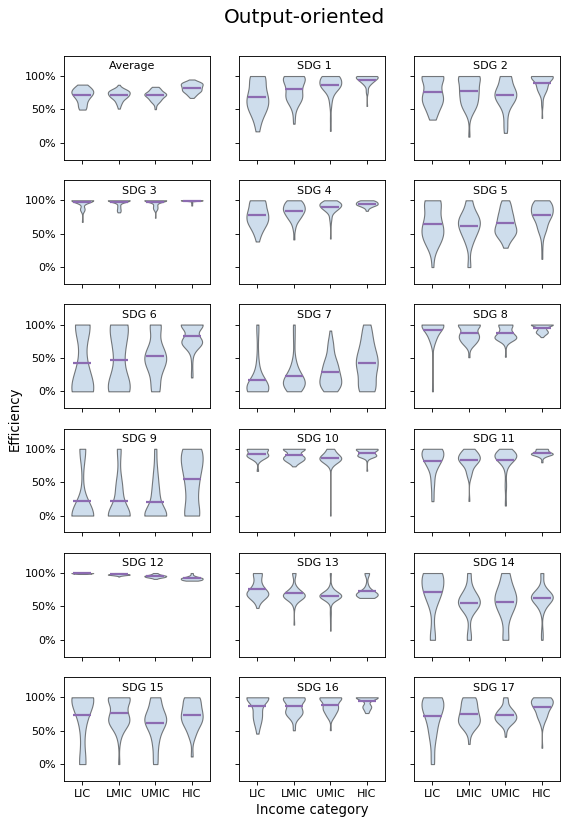

In [282]:
# beanplots - 6x3 grid

def bean(data, labels, ax, plot_opts={}, jitter=False):
    plot_opts_ = {}
    #              {'cutoff_val':5, 'cutoff_type':'abs',
    #             'label_fontsize':'small',
    #             'label_rotation':30}
    plot_opts_.update(plot_opts)
    sm.graphics.beanplot(data, ax=ax, labels=labels,
                         jitter=jitter, plot_opts=plot_opts_, side='both')
    # ax.set_xlabel("Income category")
    # ax.set_ylabel("Average efficiency")
    
def box(data, labels, ax):
    ax.boxplot(data, labels=labels, notch=False, whis=[5,95])

def violin_box(data, labels, ax, plot_opts={}):
    sm.graphics.violinplot(data, ax=ax, labels=labels, plot_opts=plot_opts)

def bean_jitter(data, labels, ax, plot_opts, jitter=True):
    sm.graphics.beanplot(data, ax=ax, labels=labels, jitter=jitter, plot_opts=plot_opts)

fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True, sharey=True)
ax = ax.ravel()
for jj,ax0 in enumerate(ax):
    if jj == 0:
        data = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
        ax0.text(.31,.87,'Average',transform=ax0.transAxes)
        # ax0.set_title('Average')
    else:
        sdg_n = ''.join(('sdg',str(jj)))
        data = [eff[sdg_n][eff['income']==ii] for ii in inc]
        ax0.text(.4,.87,''.join(('SDG ',str(jj))),transform=ax0.transAxes)
        # ax0.set_title(sdg_n)

    ax0.set_ylim(-.25,1.3)
    ax0.set_yticklabels(('','0%','50%','100%'))
    # ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

    # add a big axis, hide frame
    ax3 = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax3.set_xlabel("Income category", fontsize=12)
    ax3.set_ylabel("Efficiency", fontsize=12, labelpad=15)
    fig.suptitle('Output-oriented', y=0.93, fontsize=18)

    
    # bean(data, inc, ax0, plot_opts={'violin_width':.6, 'bean_size':0, 'bean_show_median':False, 'bean_show_mean':False, 'bean_mean_size':.5, 'violin_fc':cmap[2,:], 'bean_mean_color':cmap[0,:], 'cutoff':True})
    # box(data, inc, ax0)
    # violin_box(data, inc, ax0, plot_opts={'cutoff':True})
    # bean_jitter(data, inc, ax0, plot_opts={'cutoff_val':5, 'cutoff_type':'abs', 'label_fontsize':'small',
    #                                       'label_rotation':30, 'violin_fc':(0.8, 0.8, 0.8), 'jitter_marker':'.',
    #                                       'jitter_marker_size':1, 'bean_color':'#FF6F00', 'bean_mean_color':'#009D91'})

    # bean_jitter(data, inc, ax0, plot_opts={'cutoff':True, 'violin_fc':(0.9, 0.9, 0.9), 'jitter_marker':'.',
    #                                       'jitter_marker_size':1.5, 'bean_color':cmap[0,:], 'bean_mean_color':cmap[2,:], 'bean_show_median':False})

    # only violin and mean, no data
    bean(data, inc, ax0, plot_opts={'violin_width':.6, 'bean_size':0, 'bean_show_median':False, 
                                    'bean_show_mean':True, 'bean_mean_size':.5, 'violin_fc':cmap[2,:], 
                                    'bean_mean_color':cmap[0,:], 'cutoff':True})
    
# plt.savefig('figures/abc.png', bbox_inches='tight', dpi=150)

### Histograms

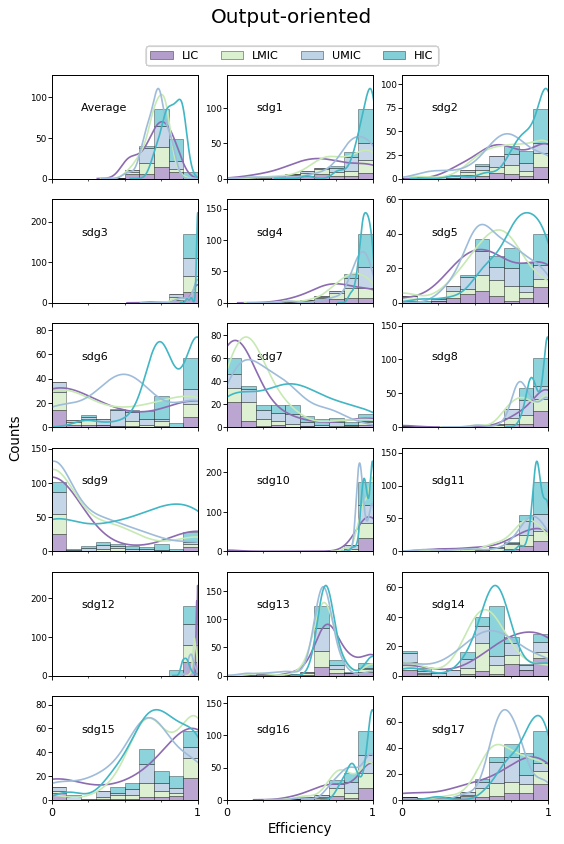

In [36]:
# stacked hist & KDE in one, every and all SDGs

aa = 0.6

def make_hist_kde(fig,ax):
    maxy2_mult = 1.15
    maxy1_mult = 1.5

    for jj,ax0 in enumerate(ax):
        ax00 = ax0.twinx()
        if jj == 0:
            histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
            ax0.text(.2,.65,'Average',transform=ax0.transAxes)
            pos1 = ax0.get_position()
        else:
            sdg_n = ''.join(('sdg',str(jj)))
            histdata = [eff[sdg_n][eff['income']==ii] for ii in inc]
            ax0.text(.2,.65,sdg_n,transform=ax0.transAxes)

        ybins, xbins, _ = ax0.hist(histdata, bins=np.linspace(0, 1, num=11), stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=aa)
        pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax00, legend=False, alpha=1)
        ax0.set_xlim(0,1)

        # automatically adjust ylim for both axes
        maxy_hist = maxy1_mult*np.stack(ybins).max()
        ax0.set_ylim(0,maxy_hist)
        maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax00.lines])
        ax00.set_ylim(0,maxy_kde)

        ax00.yaxis.set_visible(False)
        ax0.set_xticks([0,1])
        ax0.set_xticklabels([0,1])
        ax0.tick_params(axis='y', which='major', labelsize=8, pad=1)

        handles, labels = ax0.get_legend_handles_labels()
        leg = fig.legend(handles, labels, loc='center', bbox_to_anchor=[0.5,0.9], ncol=4, bbox_transform=fig.transFigure)



fig, ax = plt.subplots(6,3, figsize=(8, 12), dpi=80, facecolor='w', edgecolor='k', sharex=True)
ax = ax.ravel()
make_hist_kde(fig,ax)

# add a big axis, hide frame
ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax3.set_xlabel("Efficiency", fontsize=12)
ax3.set_ylabel("Counts", fontsize=12)


fig.suptitle('Input-oriented', y=0.95, fontsize=18)
# plt.savefig('figures/stackedhist2_kde_all_io.png', bbox_inches='tight', dpi=600)

if orient=='oo':
    fig.suptitle('Output-oriented', y=0.95, fontsize=18)
elif orient=='io':
    fig.suptitle('Input-oriented', y=0.95, fontsize=18)

plt.savefig('figures/kde_hist_{0}.png'.format(orient), bbox_inches='tight', dpi=600)



In [26]:
# histogram of average efficies across SDGs, stacked by income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
plt.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)

plt.xlabel('Average efficiency')
plt.ylabel('Number of countries')
plt.legend()

# reverse legend order
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

NameError: name 'nbins' is not defined

(0, 4)

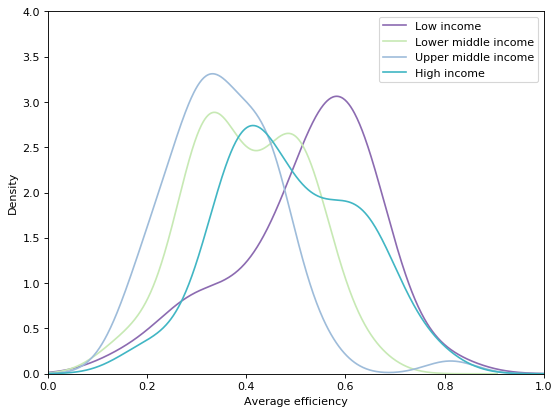

In [14]:
# KDE plot of average efficiencies across SDGs, for each income category

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]

ax = pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = plt.gca())
plt.xlabel('Average efficiency')
plt.ylabel('Density')
plt.legend(['High income', 'Upper middle income', 'Lower middle income', 'Low income'][::-1])
# plt.axes([0,1.2,0,4])
ax.set_xlim(0,1)
ax.set_ylim(0,4)

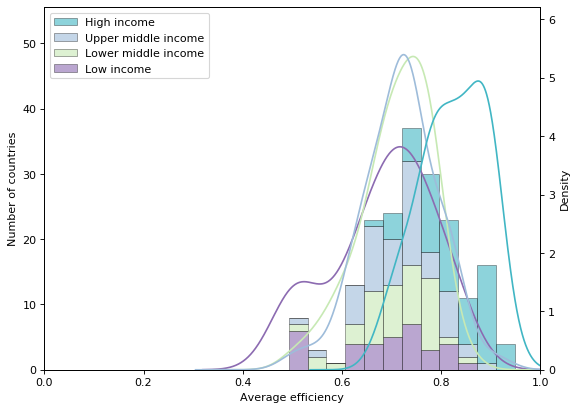

In [315]:
# stacked hist & KDE, in same plot
maxy2_mult = 1.15
maxy1_mult = 1.5

fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax.twinx()

histdata = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
ybins, xbins, _ = ax.hist(histdata, bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2, alpha=.6)

pd.concat(histdata, axis=1).plot.kde(color=cmap, ax = ax2, legend=False, alpha=1)
ax.set_xlim(0,1)

# automatically adjust ylim for both axes
maxy_hist = maxy1_mult*np.stack(ybins).max()
ax.set_ylim(0,maxy_hist)
maxy_kde = maxy2_mult*max([ll.get_ydata().max() for ll in ax2.lines])
ax2.set_ylim(0,maxy_kde)

ax.set_ylabel('Number of countries')
# ax.set_xlabel('Average efficiency')
ax.set_xlabel('Average efficiency')
# ax.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'], loc=2)

***
***
## old not-so-good ideas below

Text(0.5, 1.0, 'Input-oriented')

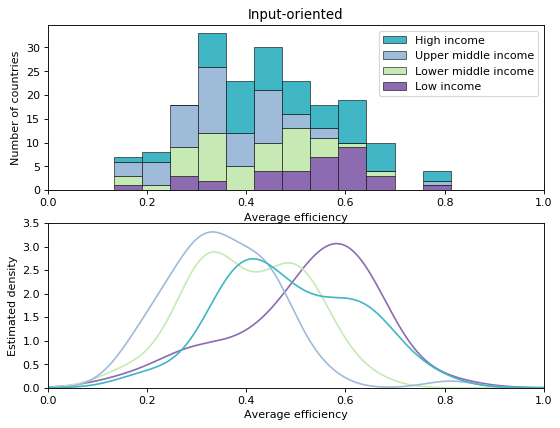

In [58]:
# stacked hist & KDE, in subplots

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6), dpi=80, sharex=False, facecolor='w', edgecolor='k')
ax1.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax = ax2, legend=False)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax2.set_ylim(0,3.5)
ax1.set_ylabel('Number of countries')
ax1.set_xlabel('Average efficiency')
ax2.set_xlabel('Average efficiency')
ax2.set_ylabel('Estimated density')

# legend in correct order
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], ['High income', 'Upper middle income', 'Lower middle income', 'Low income'])

ax1.set_title('Input-oriented')

# plt.savefig('figures/stackedhist_kde_io.png', bbox_inches='tight', dpi=600)


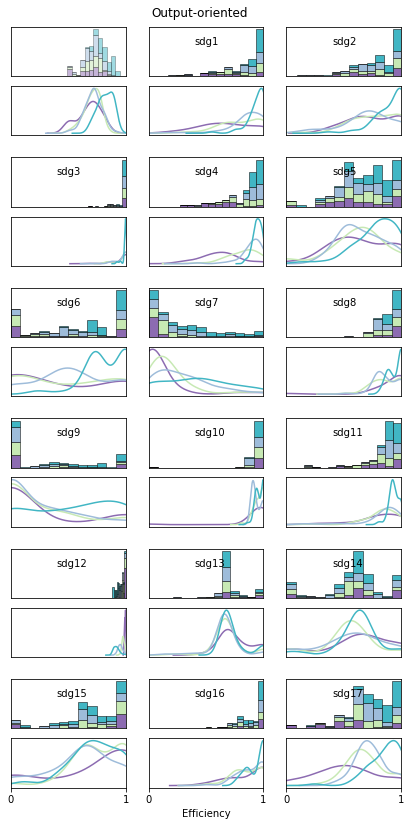

In [178]:
# stacked hist & KDE as subplots, every and all SDGs

def format_subplots(ax0,ax1):
    ax0.set_xlim(0,1)
    ax1.set_xlim(0,1)
    # ax0.set_ylim(0,100)
    # ax1.set_ylim(0,100)
    ax0.get_yaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax0.get_xaxis().set_visible(False)
    
def allsdg_hist_kde(fig):
    a = 1
    ax0 = fig.axes[0]
    ax1 = fig.axes[1]
    ax0.hist([eff[eff['income']==ii].iloc[:,1:].mean(axis=1) for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
    av_eff = [eff[eff['income']==ii].mean(axis=1) for ii in inc]
    pd.concat(av_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
    format_subplots(ax0,ax1)
    ax1.get_xaxis().set_visible(False)
    ax0.set_ylabel('Histogram')
    ax1.set_ylabel('Density')

def onesdg_hist_kde(fig):
    for jj, (ax0,ax1) in enumerate(zip(fig.axes[2::2], fig.axes[3::2])):
        sdg_n = ''.join(('sdg',str(jj+1)))
        ax0.hist([eff[sdg_n][eff['income']==ii] for ii in inc], bins = nbins, stacked=True, color=cmap, label=inc, edgecolor='k', linewidth=0.5, zorder=2)
        single_eff = [eff[sdg_n][eff['income']==ii] for ii in inc]
        pd.concat(single_eff, axis=1).plot.kde(color=cmap, ax=ax1, legend=False)
        format_subplots(ax0,ax1)
        ax0.text(.4,.65,sdg_n,transform=ax0.transAxes)
        if jj>=14:
            ax1.set_xticks([0,1])
            ax1.set_xticklabels([0,1])
            if jj == 15:
                ax1.set_xlabel('Efficiency')
        else:
            ax1.get_xaxis().set_visible(False)


f = plt.figure()
gs0 = gridspec.GridSpec(6, 3, figure=f)
for ii in range(18):
    gs01 = gs0[ii].subgridspec(2,1)
    f.add_subplot(gs01[0])
    f.add_subplot(gs01[1])

allsdg_hist_kde(f)
onesdg_hist_kde(f)
f.suptitle('Output-oriented', y=0.9)
f.set_size_inches([7,14])

# plt.savefig('figures/stackedhist_kde_all_oo.png', bbox_inches='tight', dpi=600)

In [ ]:
# if ax.is_last_row():
#     ax.spines['bottom'].set_visible(True)
# if ax.is_first_col():